In [1]:
import tensorflow as tf
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import img_as_bool

%matplotlib inline

2024-05-23 01:33:52.676976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 01:33:52.728008: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/drozdovmk/anaconda3/envs/holo/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print(tf.test.is_gpu_available())
print(tf.test.is_built_with_cuda())

tf.config.experimental.get_memory_info('GPU:0')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
True


2024-05-23 01:33:53.718832: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 01:33:53.731384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-23 01:33:53.749902: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-23 01:33:53.750057: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node,

{'current': 0, 'peak': 0}

(2048, 2048)
(34, 34)


(array([ 0.,  0.,  0.,  0.,  0., 34.,  0.,  0.,  0.,  0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

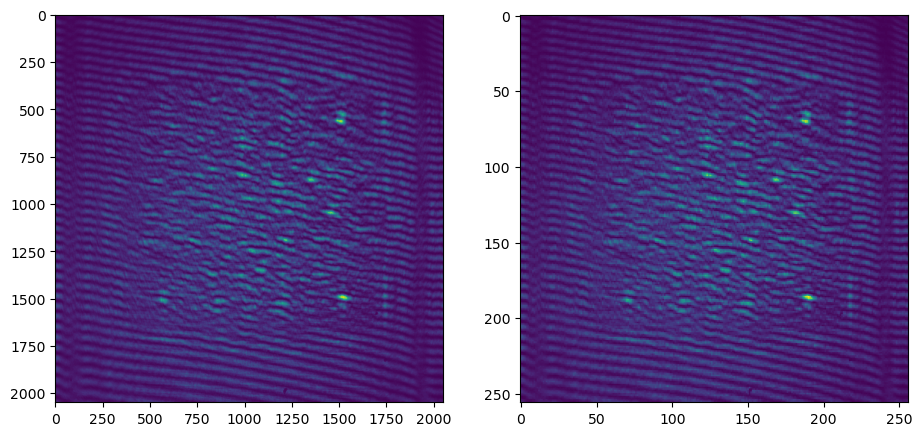

In [3]:
holo_path = '/home/drozdovmk/holo_data/25_inline/HOLO_25_inline/'
qr_path = '/home/drozdovmk/holo_data/25_inline/QR_25_inline/'

files = os.listdir(qr_path)
image = cv2.imread(qr_path + '0.png', cv2.IMREAD_GRAYSCALE)
holo = cv2.imread(holo_path + '0.png',cv2.IMREAD_GRAYSCALE )
# Display the image
fig,ax = plt.subplots(1,2, figsize = (11,8))
print(holo.shape)
print(image.shape)
ax[0].imshow(holo)
# ax[1].imshow(image)

ax[1].imshow(cv2.resize(holo, (256,256),) )
plt.hist(image[0])

# from PIL import Image
# im = Image.fromarray(cv2.resize(holo, (256,256)))
# im.save("your_file.jpeg")

In [4]:

random_seed = 44
def binarize_image(image, threshold = 30):
    binary_image = tf.where(image < threshold, 0, 1)
    return binary_image
def normalize_image(image):
    return tf.cast(image, tf.float32) / 255.0
def crop_image(image):
    cropped_image = tf.image.crop_to_bounding_box(image, 35, 35, 256-72, 256-72)  # Пример обрезки изображения
    return cropped_image
def combine_datasets(input_ds, output_ds):
    dataset = tf.data.Dataset.zip((input_ds, output_ds))
    return dataset
def create_dataset(qr_path, holo_path, crop = True):
    qr_train, qr_val = tf.keras.preprocessing.image_dataset_from_directory(qr_path, labels = None,
                                                    color_mode = 'grayscale', batch_size = 8, image_size = (256, 256),
                                                    subset = 'both', validation_split=0.15, seed = random_seed, )
    holo_train, holo_val = tf.keras.preprocessing.image_dataset_from_directory(holo_path, labels = None,
                                                    color_mode = 'grayscale', batch_size = 8, image_size = (256, 256),
                                                    subset = 'both', validation_split=0.15, seed = random_seed)
    if crop:
        holo_train_cropped = holo_train.map(crop_image).map(normalize_image)
        holo_val_cropped = holo_val.map(crop_image).map(normalize_image)

        qr_train_cropped = qr_train.map(crop_image)
        qr_val_cropped = qr_val.map(crop_image)

        qr_train_cropped_binarized = qr_train_cropped.map(binarize_image, 30)
        qr_val_cropped_binarized = qr_val_cropped.map(binarize_image, 30)

        train_dataset = combine_datasets(holo_train_cropped, qr_train_cropped_binarized)
        val_dataset = combine_datasets(holo_val_cropped, qr_val_cropped_binarized)
        return train_dataset, val_dataset
    else:
        train_dataset = combine_datasets(holo_train, qr_train)
        val_dataset = combine_datasets(holo_val, qr_val)
        return train_dataset, val_dataset

In [5]:
train_dataset, val_dataset = create_dataset(qr_path, holo_path, crop = True)

Found 9994 files belonging to 1 classes.
Using 8495 files for training.
Using 1499 files for validation.
Found 9994 files belonging to 1 classes.
Using 8495 files for training.
Using 1499 files for validation.


(8, 184, 184, 1)
(8, 184, 184, 1)


<tf.Tensor: shape=(184, 184), dtype=float32, numpy=
array([[0.10588235, 0.11470588, 0.09901961, ..., 0.10098039, 0.07843138,
        0.0882353 ],
       [0.10196079, 0.10980392, 0.09215686, ..., 0.08235294, 0.07352941,
        0.08529412],
       [0.07352941, 0.08137255, 0.07941177, ..., 0.1127451 , 0.08333334,
        0.07058824],
       ...,
       [0.18431373, 0.16176471, 0.14607844, ..., 0.09509804, 0.09313726,
        0.11862745],
       [0.18039216, 0.17058824, 0.17058824, ..., 0.08529412, 0.10196079,
        0.10784314],
       [0.16176471, 0.14313726, 0.14117648, ..., 0.12156863, 0.11960784,
        0.10196079]], dtype=float32)>

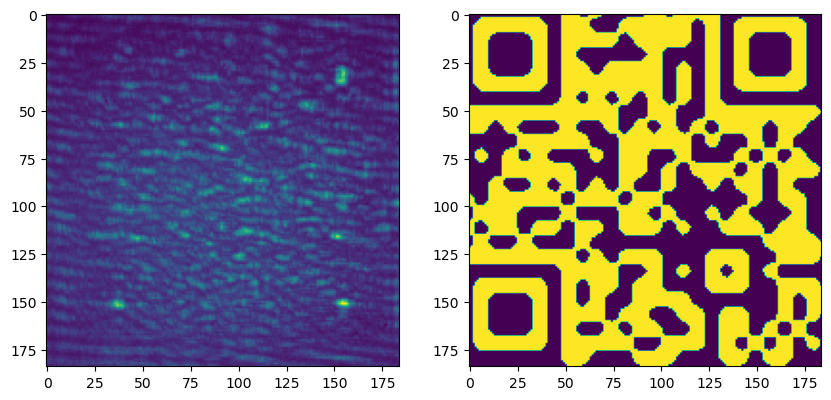

In [6]:

fig,ax = plt.subplots(1,2, figsize = (10, 8))
i = 3
for x, y in train_dataset:
    ax[0].imshow(x[i,:,:,0])
    ax[1].imshow(y[i,:,:,0])
    print(x.shape)
    print(y.shape)
    break
x[0,:,:,0]

In [7]:
from unet_keras import unet_keras
unet = unet_keras()
unet.build(input_shape = (8, 184,184,1))
unet.summary()

Model: "unet_keras_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling2d_1 (Averag  multiple                 0         
 ePooling2D)                                                     
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 double_conv_with_64_and_64_  (8, 184, 184, 64)        38080     
 filters (Sequential)                                            
                                                                 
 double_conv_with_128_and_12  (8, 92, 92, 128)         222464    
 8_filters (Sequential)                                          
                                                                 
 conv2d_transpose_2 (Conv2DT  multiple                 65664     
 ranspose)                                            

In [8]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True, ),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, ),
            loss = 'binary_crossentropy',
            metrics = [SSIMLoss,'accuracy'],)

In [9]:
history = unet.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10


2024-05-23 01:34:13.529851: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8907
2024-05-23 01:34:14.668541: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-23 01:34:15.525247: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.22GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-23 01:34:16.823650: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-23 01:34:17.216923: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) r

1061/1062 [============================>.] - ETA: 0s - loss: 0.5602 - SSIMLoss: 0.8218 - accuracy: 0.6553

2024-05-23 01:37:28.976233: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.20GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-23 01:37:30.184389: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-23 01:37:30.548869: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.13GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-23 01:37:30.966477: W tensorflow/core/common_runtime/bfc_allocato

1062/1062 [==============================] - 211s 193ms/step - loss: 0.5602 - SSIMLoss: 0.8217 - accuracy: 0.6553 - val_loss: 0.5044 - val_SSIMLoss: 0.7605 - val_accuracy: 0.6895
Epoch 2/10
1062/1062 [==============================] - 203s 191ms/step - loss: 0.4785 - SSIMLoss: 0.7204 - accuracy: 0.6979 - val_loss: 0.4752 - val_SSIMLoss: 0.7161 - val_accuracy: 0.7069
Epoch 3/10
1062/1062 [==============================] - 203s 191ms/step - loss: 0.4543 - SSIMLoss: 0.6864 - accuracy: 0.7114 - val_loss: 0.4499 - val_SSIMLoss: 0.6676 - val_accuracy: 0.7174
Epoch 4/10
1062/1062 [==============================] - 204s 192ms/step - loss: 0.4399 - SSIMLoss: 0.6660 - accuracy: 0.7202 - val_loss: 0.4377 - val_SSIMLoss: 0.6501 - val_accuracy: 0.7249
Epoch 5/10
1062/1062 [==============================] - 203s 191ms/step - loss: 0.4293 - SSIMLoss: 0.6510 - accuracy: 0.7269 - val_loss: 0.4323 - val_SSIMLoss: 0.6485 - val_accuracy: 0.7292
Epoch 6/10
1062/1062 [==============================] - 203s 

In [17]:
unet.save('unet1')

INFO:tensorflow:Assets written to: unet1/assets


INFO:tensorflow:Assets written to: unet1/assets


1/1 [==============================] - 0s 13ms/step


Text(0.5, 1.0, 'Реальное изображение')

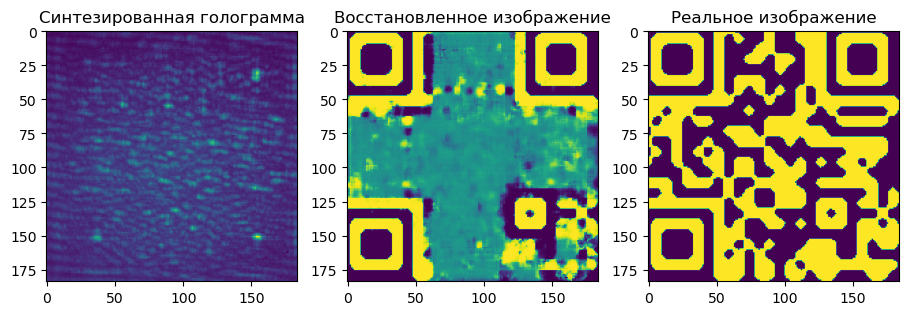

In [63]:
fig, ax = plt.subplots(1,3, figsize = (11,8))
i = 0
ax[0].imshow(x[i,:,:,0])
ax[0].set_title('Синтезированная голограмма')
ax[1].imshow(unet.predict(x)[i,:,:,0])
ax[1].set_title('Восстановленное изображение')
ax[2].imshow(y[i,:,:,0])
ax[2].set_title('Реальное изображение')

In [ ]:
plt.imshow(binarize_image(unet.predict(x)[i,:,:,0], threshold=0.51))

In [30]:
unet2 = tf.keras.models.load_model('unet1',custom_objects={'SSIMLoss': SSIMLoss})
unet2

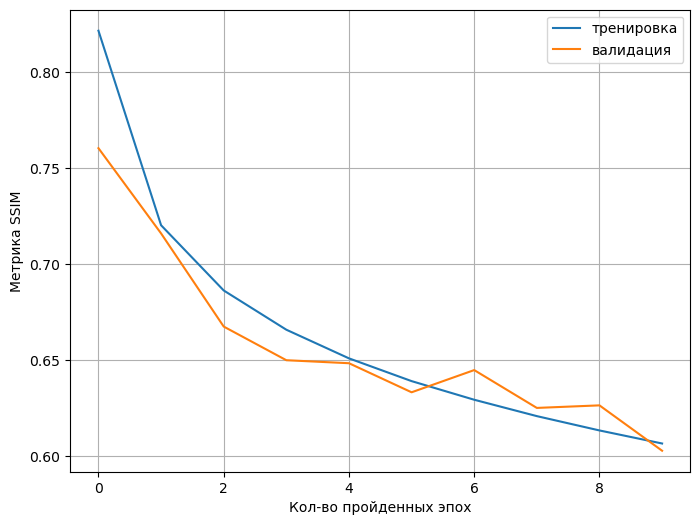

In [58]:
fig,ax = plt.subplots(1, figsize = (8,6))
ax.plot(history.history['SSIMLoss'], label = 'тренировка')
ax.plot(history.history['val_SSIMLoss'], label = 'валидация')
ax.set_ylabel('Метрика SSIM')
ax.set_xlabel('Кол-во пройденных эпох')
ax.legend()
ax.grid()

In [52]:
history.history.keys()

dict_keys(['loss', 'SSIMLoss', 'accuracy', 'val_loss', 'val_SSIMLoss', 'val_accuracy'])